## Preprocessing

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from modules.dataset import Dataset

2022-10-21 09:38:22.812739: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def get_y_true(data):
    y_true=[]
    for X,y in data:
        for label in y:
            y_true.append(label)
    y_true = tf.Variable(y_true)
    return y_true

In [3]:
# Constant variables
# NAME = "ResNet50"
EPOCHS = 10
NUM_FOLDS = 5

dataset = Dataset()
fold_num = 5

# Dataset
train_dataset, test_dataset = dataset.get_kfold(fold_num, sample=False)

# Modeling
model = tf.keras.models.load_model(f"results/models/Resnet50_Dropout_02_imagenet_fold_{fold_num}.h5")

2022-10-21 09:38:25.807277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-21 09:38:27.555482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31997 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0


In [4]:
y_true = get_y_true(test_dataset)
y_preds = model.predict(test_dataset)

2022-10-21 09:38:53.264514: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-21 09:38:54.460778: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-21 09:38:54.461893: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-21 09:38:54.461946: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-21 09:38:54.463101: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-21 09:38:54.463218: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


      6/Unknown - 7s 24ms/step

2022-10-21 09:38:57.588741: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1402/1402 [==============================] - 45s 27ms/step


In [8]:
y_true, y_preds

(<tf.Variable 'Variable:0' shape=(22424, 15) dtype=int64, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]])>,
 array([[4.25559729e-01, 1.37823254e-01, 5.96317835e-02, ...,
         5.47628030e-02, 4.90854420e-02, 8.11573584e-04],
        [5.27761281e-01, 2.24093959e-01, 2.16166154e-02, ...,
         3.12541723e-02, 2.74951998e-02, 4.79558762e-03],
        [2.74195969e-01, 1.08266331e-01, 1.09202400e-01, ...,
         7.94784948e-02, 8.45007896e-02, 3.55462835e-04],
        ...,
        [4.45966512e-01, 4.29034382e-02, 2.19949167e-02, ...,
         1.33707836e-01, 1.05402455e-01, 7.79677357e-04],
        [6.26362383e-01, 1.45257220e-01, 2.21792329e-02, ...,
         2.68103071e-02, 1.85944065e-02, 6.44524756e-04],
        [9.41694260e-01, 4.35324805e-03, 2.07199992e-04, ...,
         9.74873640e-03, 2.00936478e-03, 1.193

In [9]:
y_true.shape, y_preds.shape

(TensorShape([22424, 15]), (22424, 15))

In [10]:
m = tf.keras.metrics.AUC(multi_label=True)
m.update_state(y_true, y_preds)
m.result().numpy()

0.72771037

## Our Utils

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from modules.dataset import LABELS

sns.set()

In [12]:
def plot_compare_split(dictionary, name, x_label, y_label):
    fig = plt.figure(figsize=(35,20))
    fig.suptitle(name, fontsize=30)
    for i, (label, value) in enumerate(dictionary.items()):
        x, y = zip(*value)

        plt.subplot(3, 5, i+1)
        plt.plot(x, y, marker='.', label=label)

        plt.title(label)
        plt.xlabel(x_label, fontweight='bold')
        plt.ylabel(y_label, fontweight='bold')
        plt.ylim(-0.05, 1.05)
        plt.xlim(-0.05, 1.05)
    plt.show()

In [13]:
def plot_compare(dictionary, name, x_label, y_label):
    plt.figure(figsize=(20,12))
    for i, (label, value) in enumerate(dictionary.items()):
        x, y = zip(*value)
        plt.plot(x, y, marker='.', label=label)

    plt.title(name)
    plt.legend()
    plt.xlabel(x_label, fontweight='bold')
    plt.ylabel(y_label, fontweight='bold')
    plt.ylim(-0.05, 1.05)
    plt.xlim(-0.05, 1.05)
    plt.show()

## F1 vs. thresholds

In [14]:
thresholds = m._thresholds

f1_thresholds_dict = dict()
true_positives, true_negatives, false_positives, false_negatives = m.variables
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(true_positives, true_negatives, false_positives, false_negatives)):
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        tp, tn, fp, fn = tp.numpy(), tn.numpy(), fp.numpy(), fn.numpy()
        f1_score = 2*tp / (2*tp + fp + fn)
        try: 
            f1_thresholds_dict[label].append((thresholds[i_thresh], f1_score))
        except:
            f1_thresholds_dict[label] = [(thresholds[i_thresh], f1_score)]

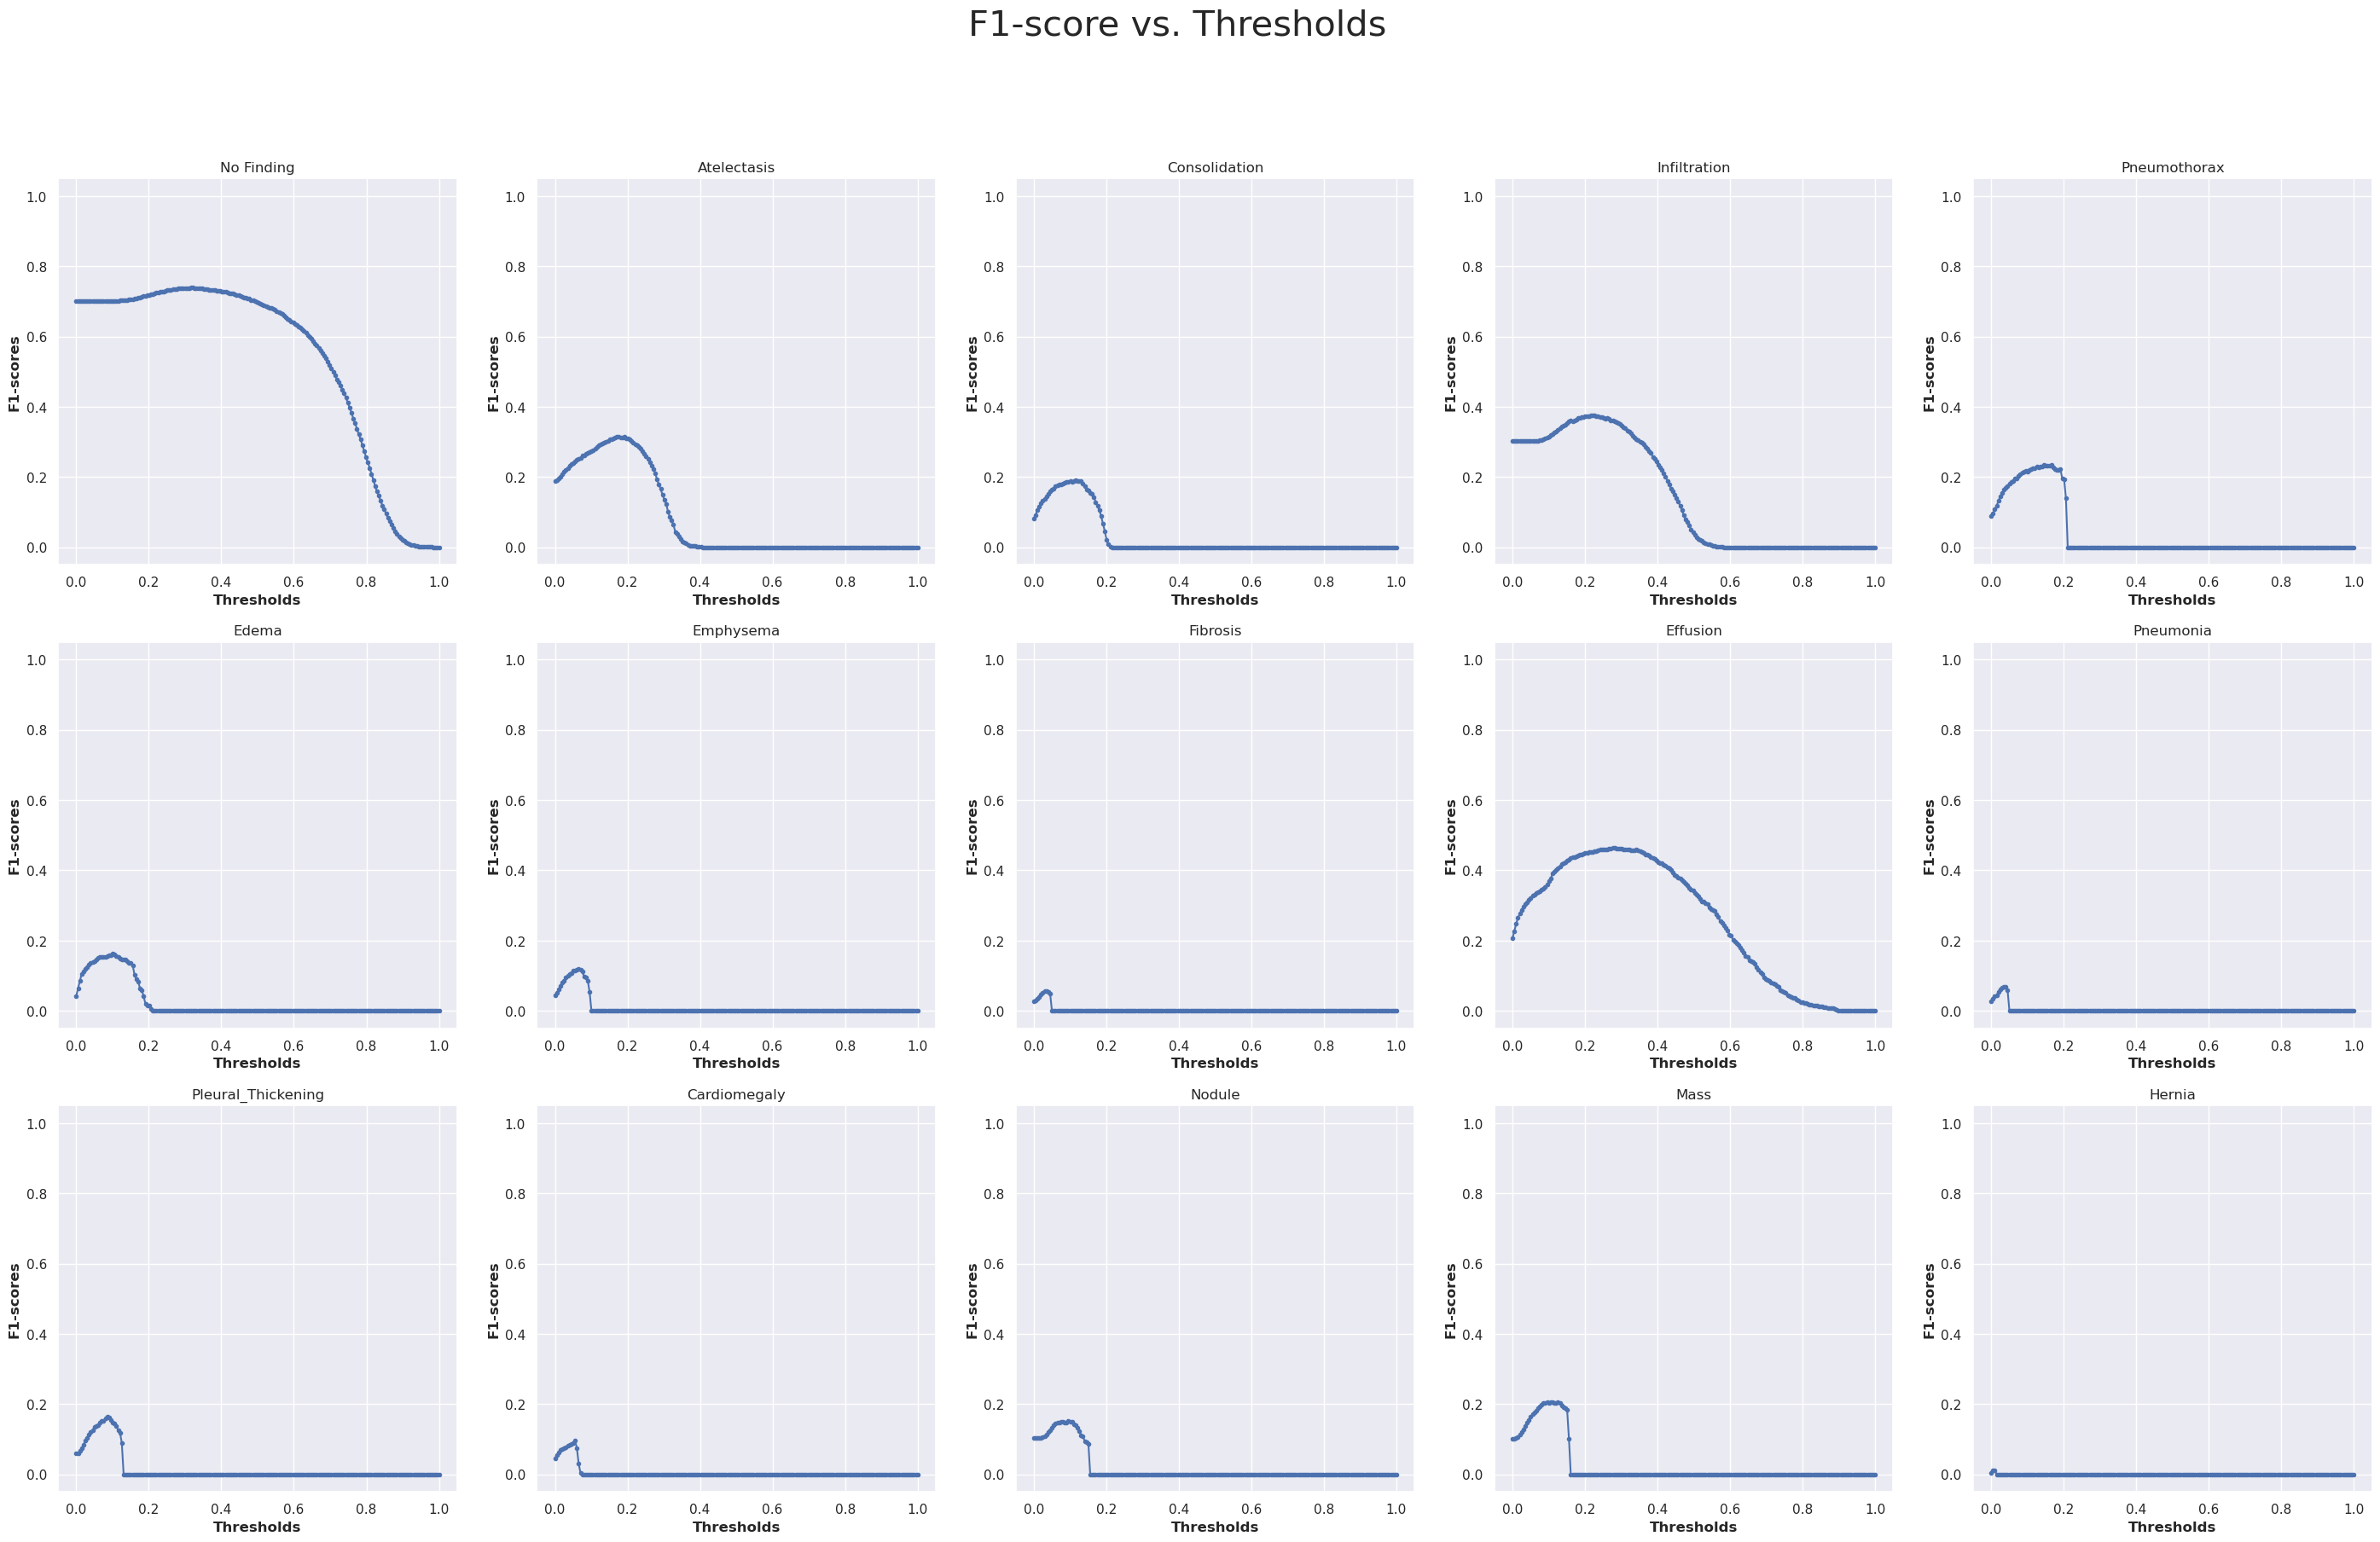

In [15]:
plot_compare_split(f1_thresholds_dict, name="F1-score vs. Thresholds", x_label='Thresholds', y_label='F1-scores')

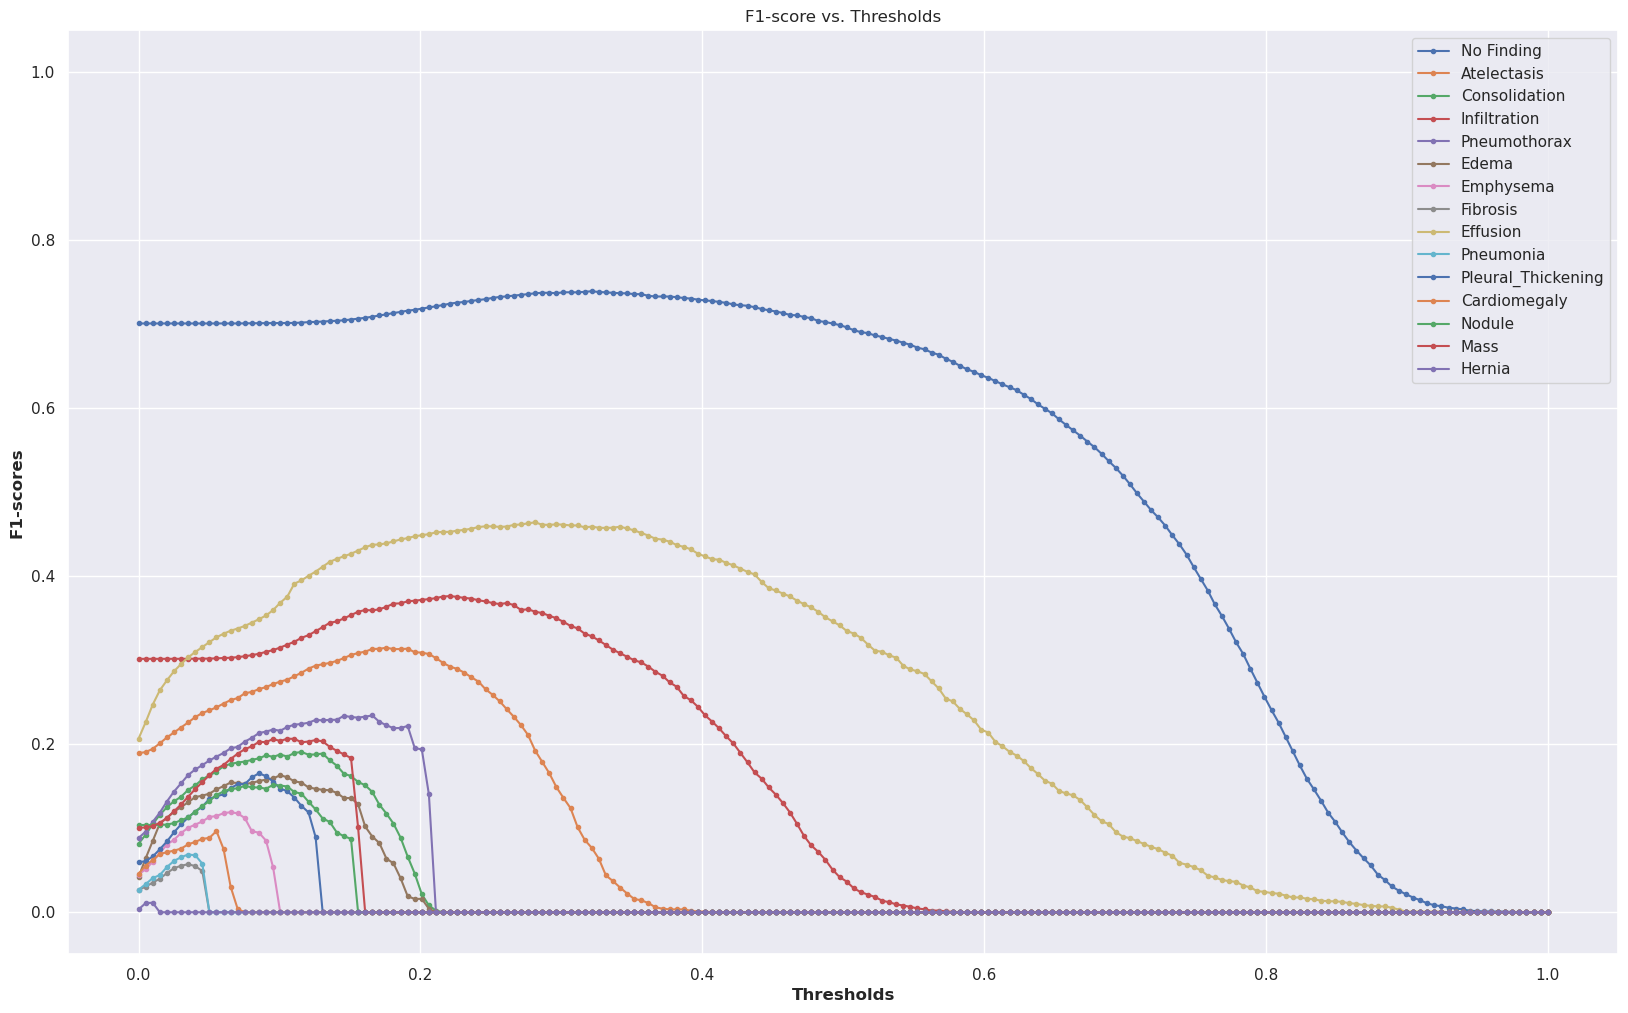

In [16]:
plot_compare(f1_thresholds_dict, name="F1-score vs. Thresholds", x_label='Thresholds', y_label='F1-scores')

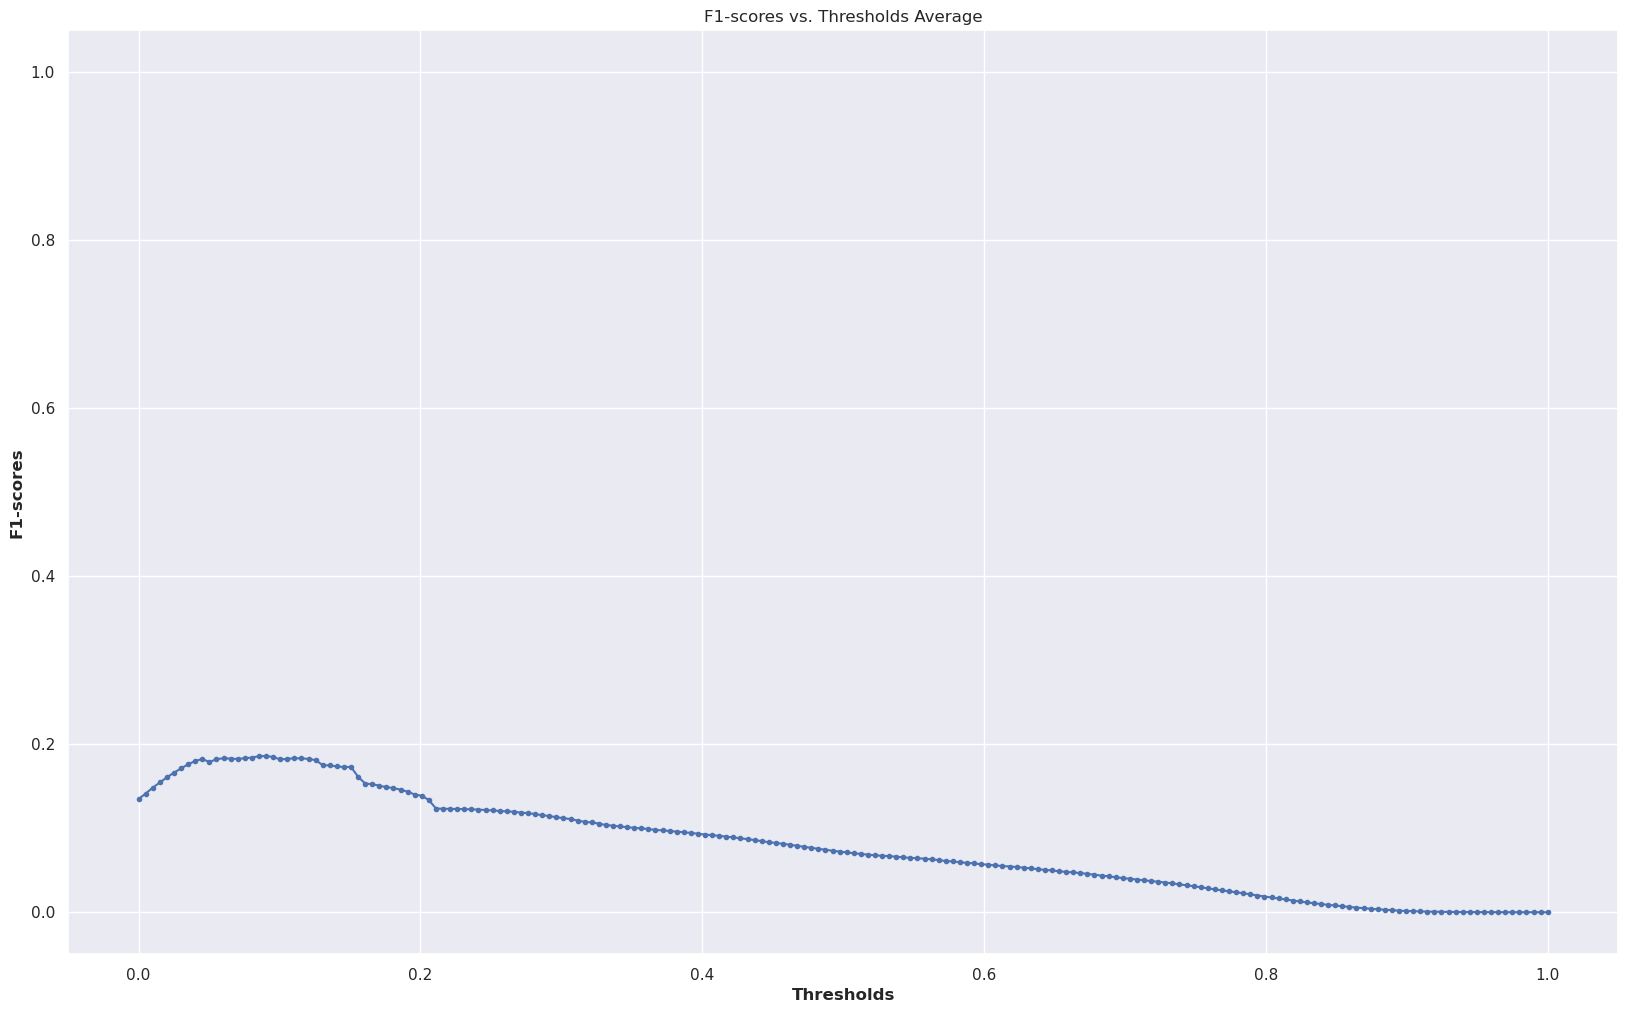

In [24]:
import numpy as np

thresholds = m._thresholds

f1_thresholds_average_list = []
true_positives, true_negatives, false_positives, false_negatives = m.variables
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(true_positives, true_negatives, false_positives, false_negatives)):
    f1_score_average = []
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        tp, tn, fp, fn = tp.numpy(), tn.numpy(), fp.numpy(), fn.numpy()
        f1_score = 2*tp / (2*tp + fp + fn)
        f1_score_average.append(f1_score)
        
    f1_score_average = np.mean(f1_score_average)
    f1_thresholds_average_list.append((thresholds[i_thresh], f1_score_average))

# Cast to numpy for vectorlize
f1_thresholds_average_list = np.array(f1_thresholds_average_list)

plt.figure(figsize=(20,12))
plt.plot(f1_thresholds_average_list[:, 0], f1_thresholds_average_list[:, 1], marker='.')
plt.title("F1-scores vs. Thresholds Average")
plt.xlabel("Thresholds", fontweight='bold')
plt.ylabel("F1-scores", fontweight='bold')
plt.ylim(-0.05, 1.05)
plt.xlim(-0.05, 1.05)
plt.show()

In [35]:
f1_thresholds_average_list[:, 1].argmax(), f1_thresholds_average_list[:, 0][18]

(18, 0.09045226130653267)

f1_thresholds_average_list[:, 1]## ROC

In [25]:
thresholds = m._thresholds
thresholds[:5]

array([-1.00000000e-07,  5.02512563e-03,  1.00502513e-02,  1.50753769e-02,
        2.01005025e-02])

In [26]:
threshold = 4
(y_preds > thresholds[threshold]).astype('int16')

array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [27]:
roc_dict = dict()
true_positives, true_negatives, false_positives, false_negatives = m.variables
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(true_positives, true_negatives, false_positives, false_negatives)):
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        tp, tn, fp, fn = tp.numpy(), tn.numpy(), fp.numpy(), fn.numpy()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        try: 
            roc_dict[label].append((tpr, fpr))
        except:
            roc_dict[label] = [(tpr, fpr)]

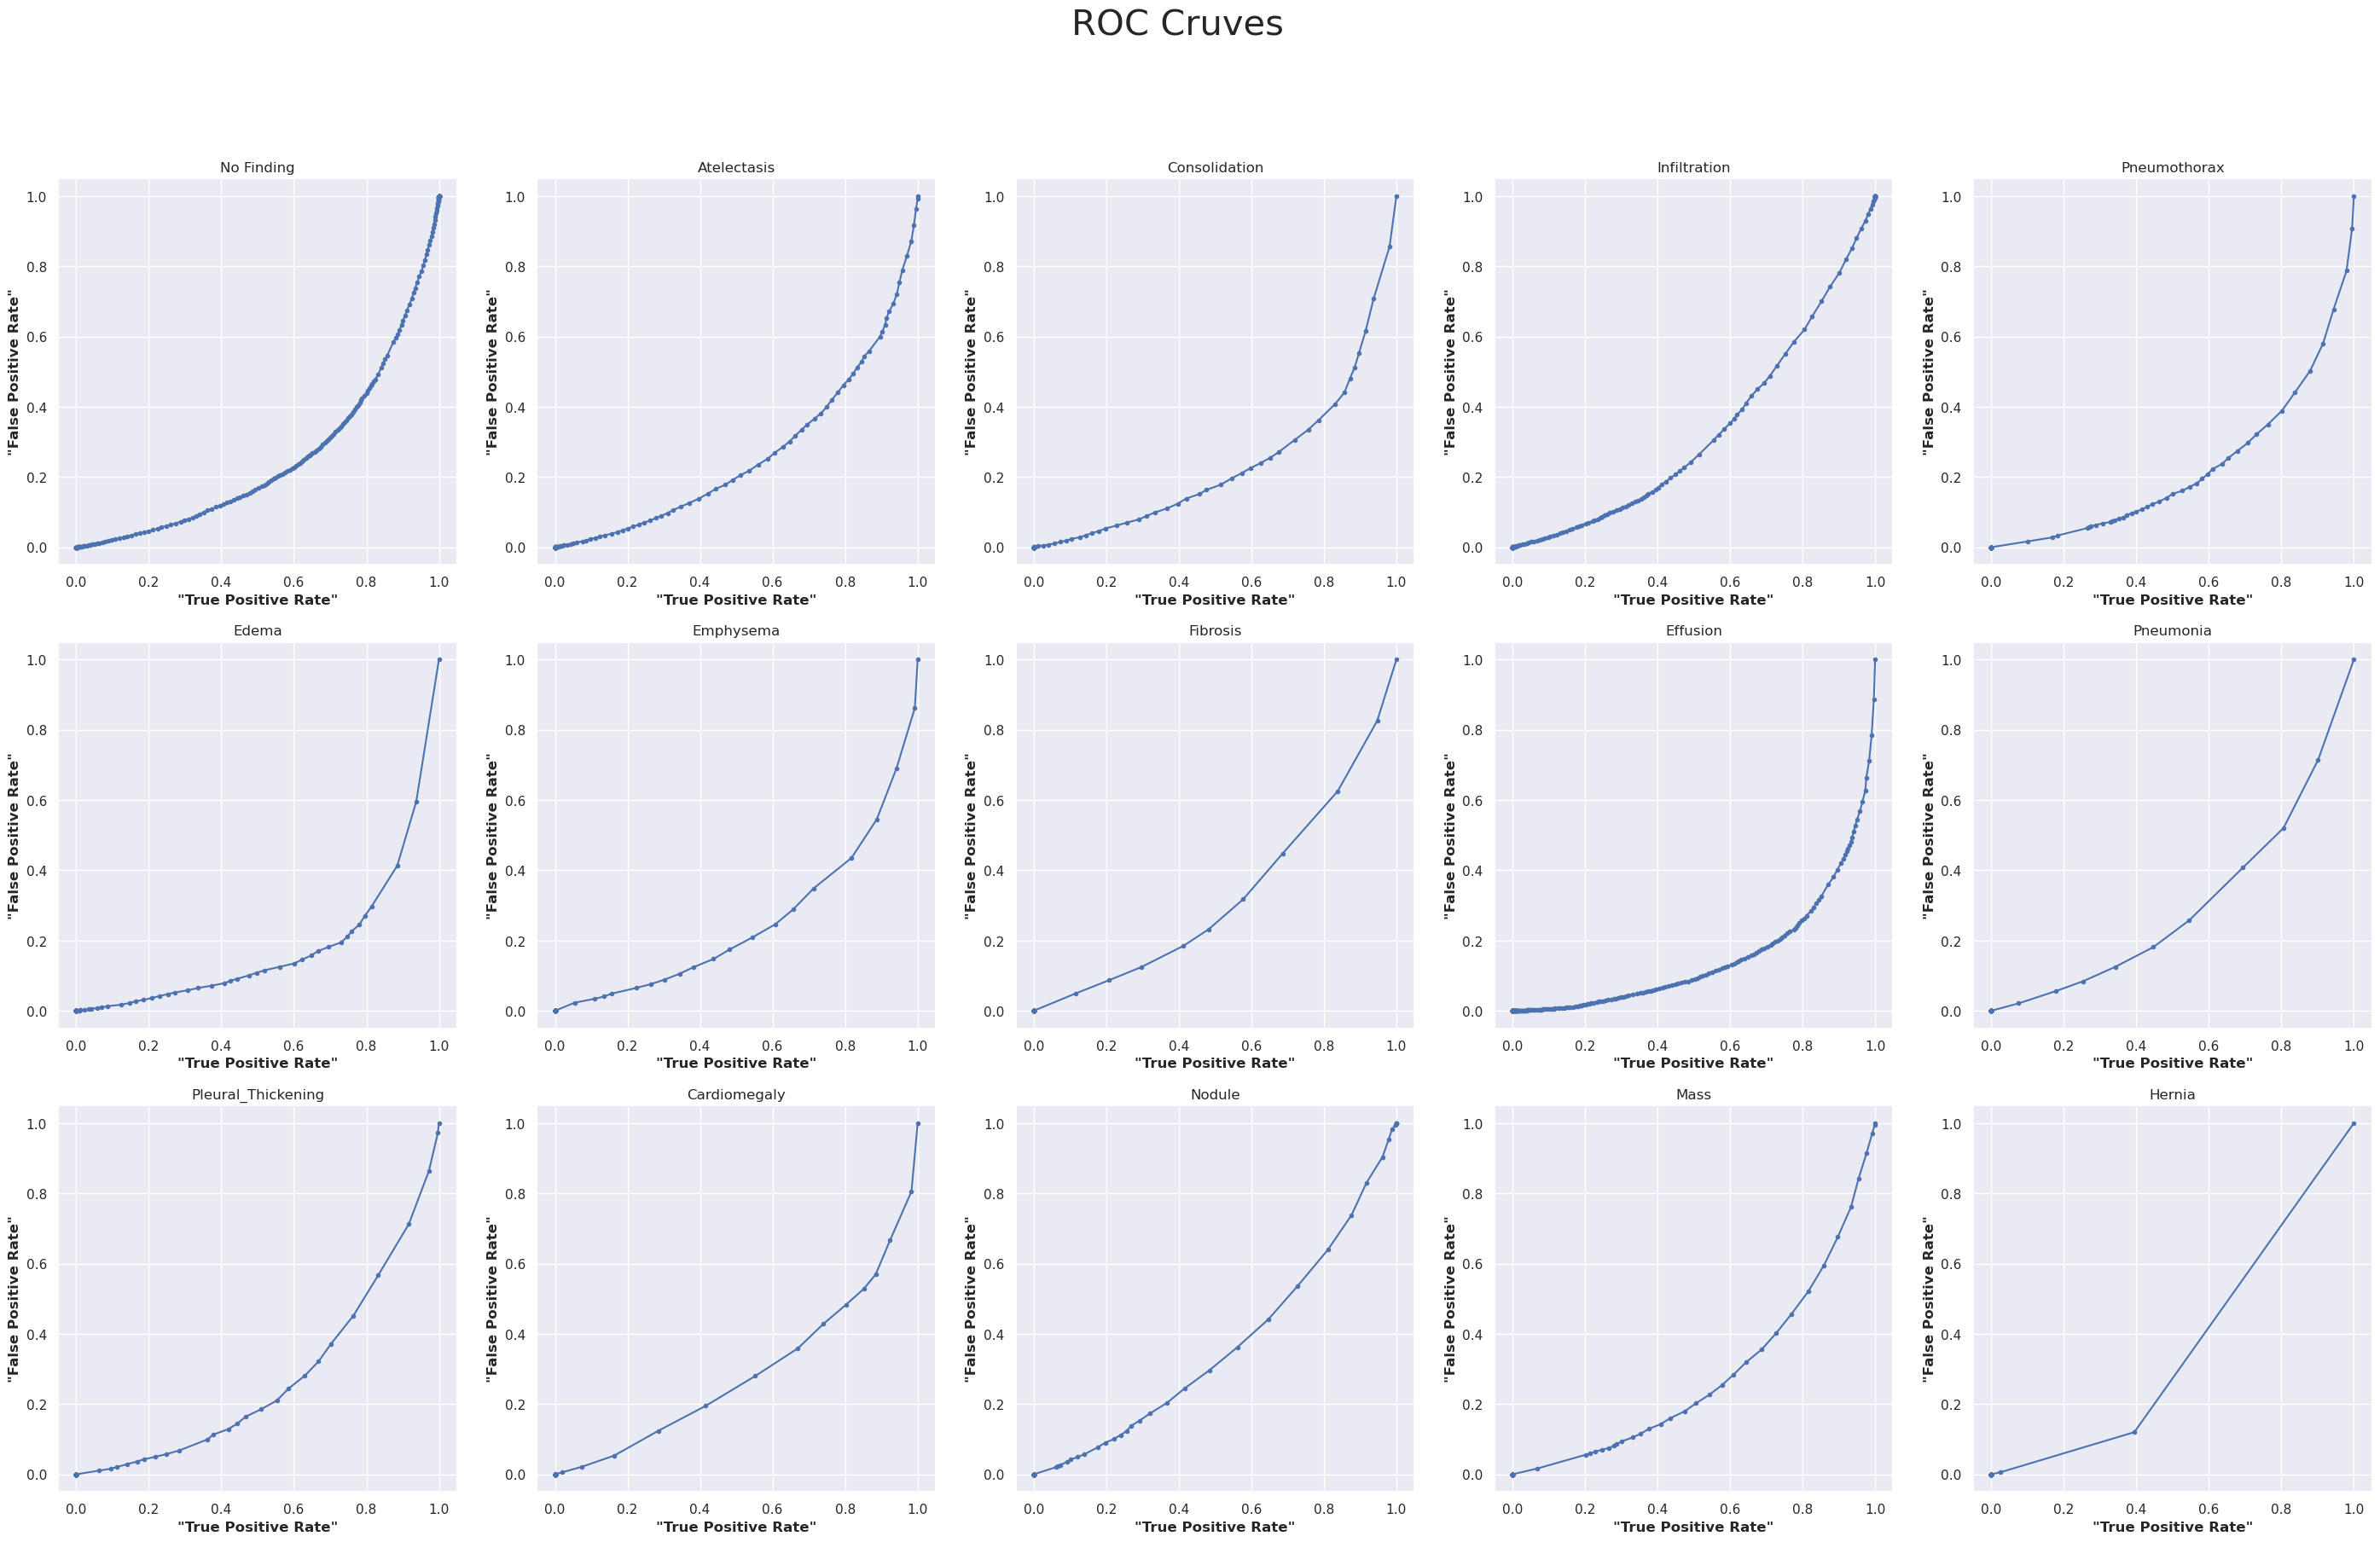

In [28]:
plot_compare_split(roc_dict, name="ROC Cruves", x_label='"True Positive Rate"', y_label='"False Positive Rate"')

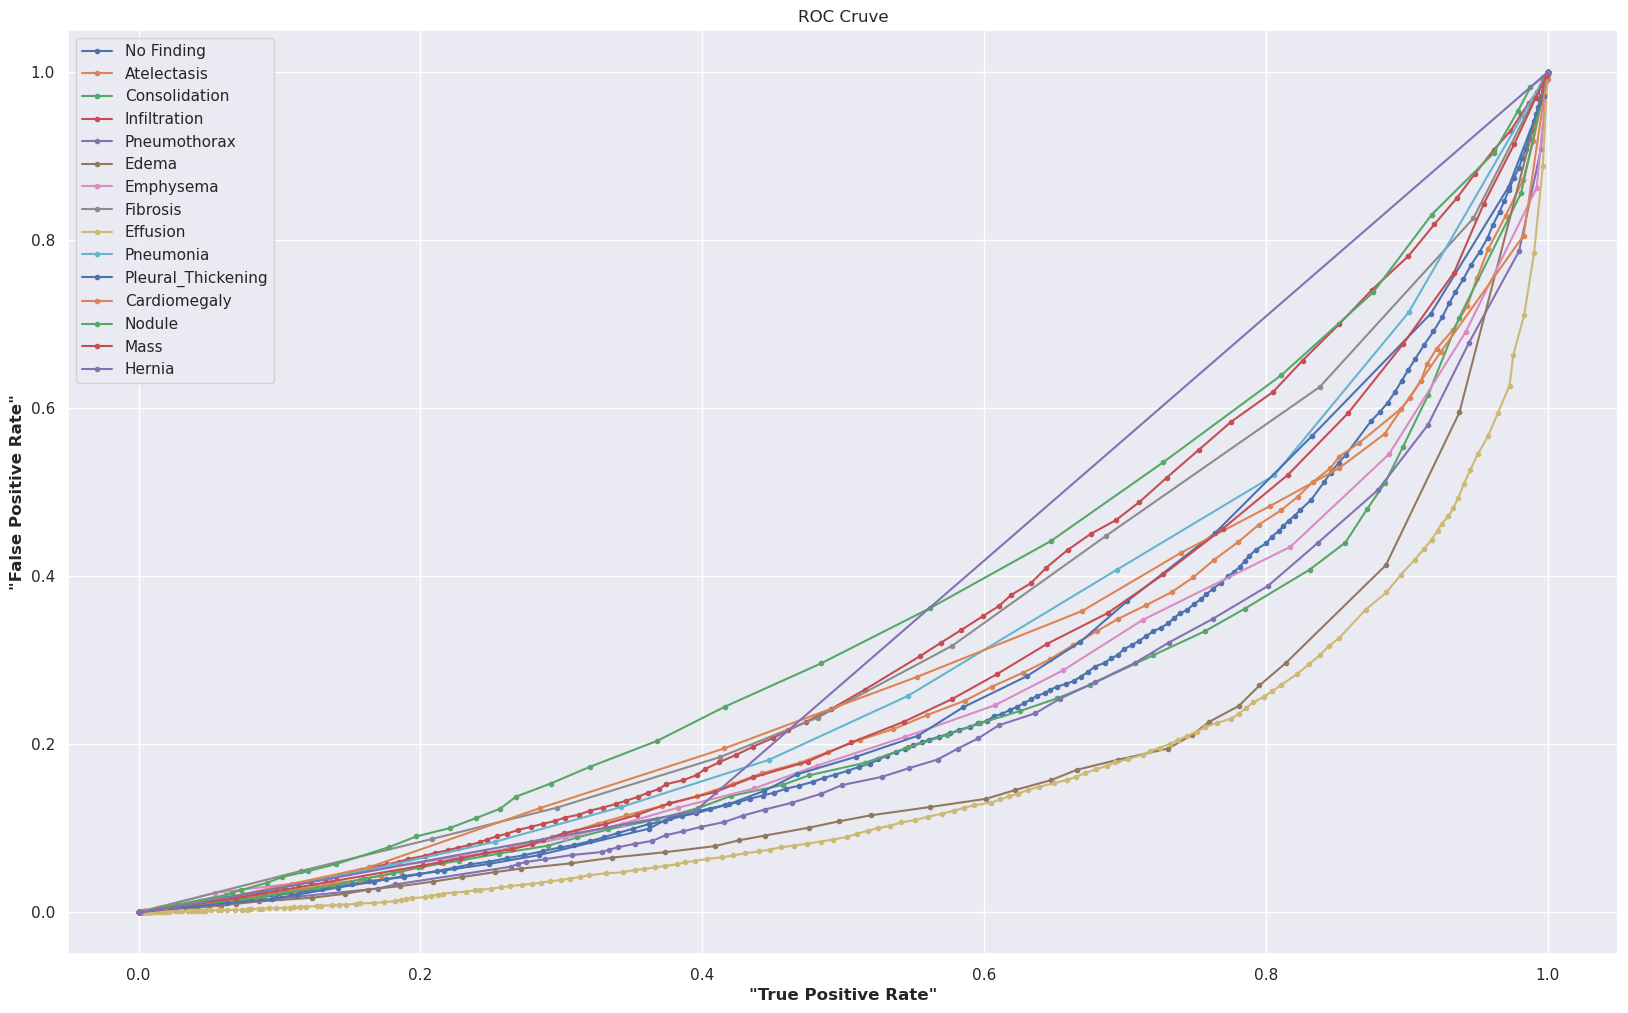

In [29]:
plot_compare(roc_dict, name="ROC Cruve", x_label='"True Positive Rate"', y_label='"False Positive Rate"')

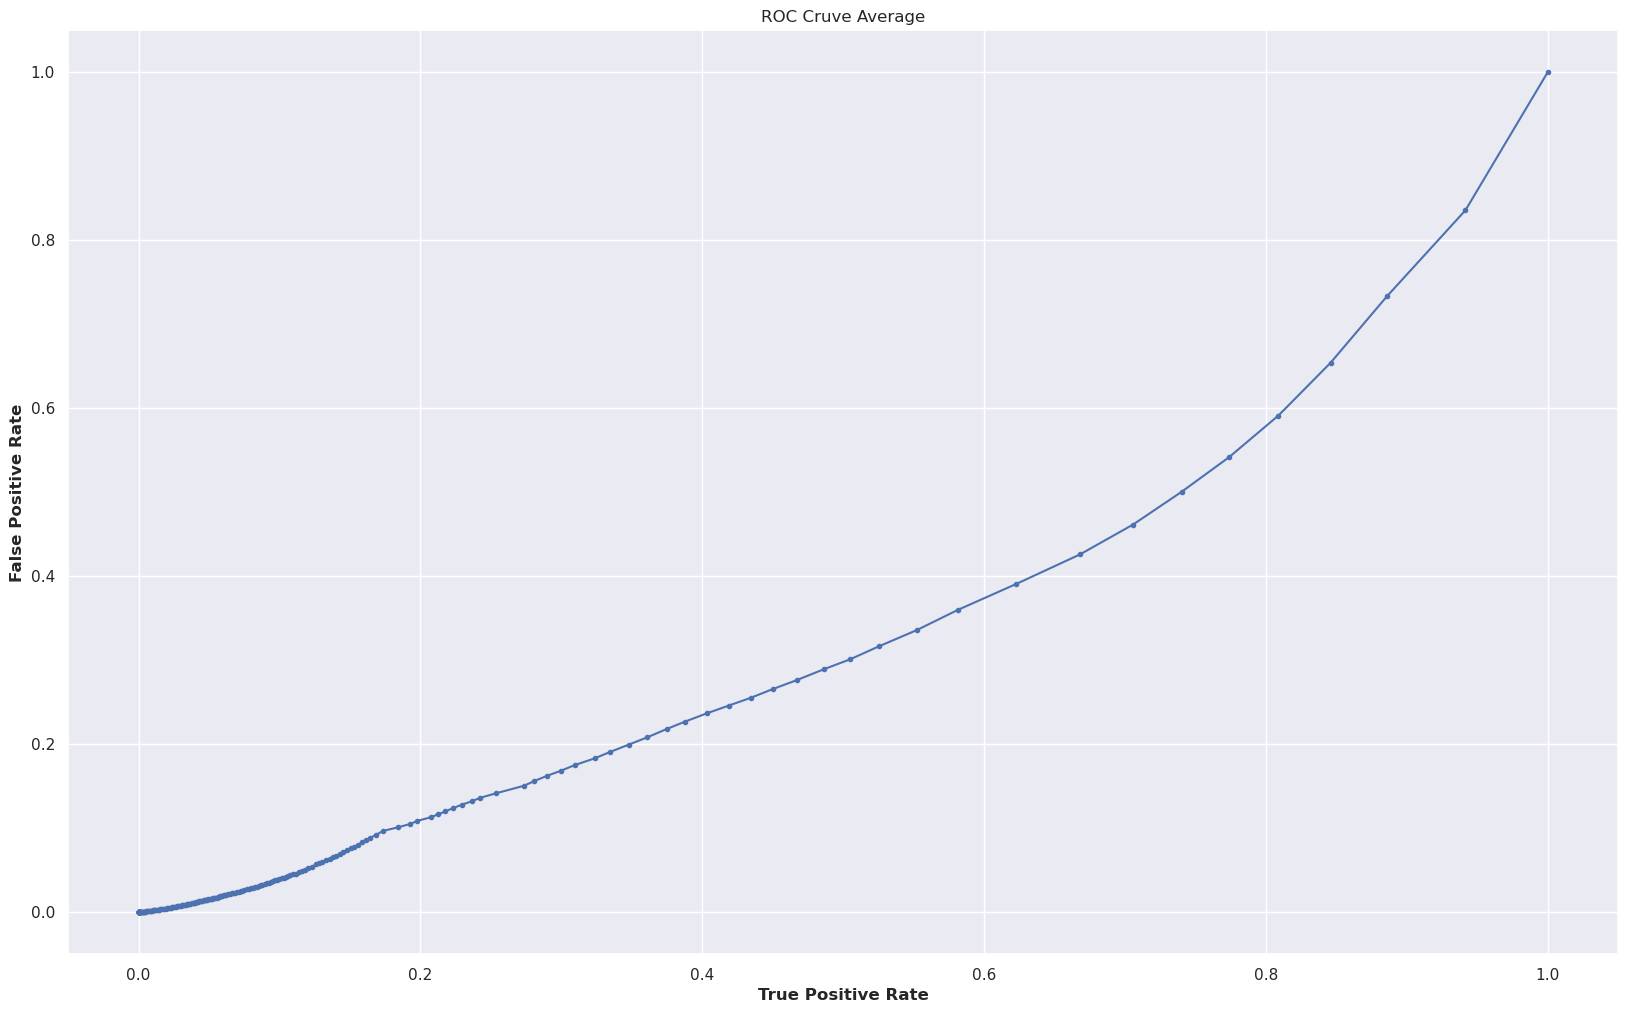

In [30]:
import numpy as np

roc_average_list = []
true_positives, true_negatives, false_positives, false_negatives = m.variables
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(true_positives, true_negatives, false_positives, false_negatives)):
    tpr_list = []
    fpr_list = []
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        tp, tn, fp, fn = tp.numpy(), tn.numpy(), fp.numpy(), fn.numpy()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    tpr_average = np.mean(tpr_list)
    fpr_average = np.mean(fpr_list)
    roc_average_list.append((thresholds[i_thresh], tpr_average, fpr_average))

# Cast to numpy for vectorlize
roc_average_list = np.array(roc_average_list)

plt.figure(figsize=(20,12))
plt.plot(roc_average_list[:, 1], roc_average_list[:, 2], marker='.')
plt.title("ROC Cruve Average")
plt.xlabel("True Positive Rate", fontweight='bold')
plt.ylabel("False Positive Rate", fontweight='bold')
plt.show()

## Confusion Metrics

In [31]:
import seaborn as sns
from modules.dataset import LABELS
import matplotlib.pyplot as plt

def plot_confusion_metics(confusion_metrics, threshold):
    fig = plt.figure(figsize=(35,20))
    fig.suptitle(f"Condusion Metrics for Threshold: {threshold}", fontsize=30)
    for i, confusion_metrix in enumerate(confusion_metrics.numpy().astype('int64')):
        plt.subplot(3, 5, i+1)
        plt.title(LABELS[i], fontweight='bold', fontsize=16)
        sns.heatmap(confusion_metrix, cbar=False, annot=True, fmt="d", cmap="Greens", linewidths=.5, annot_kws={"fontsize":24})
        plt.xlabel('"Prediction"', fontweight='bold')
        plt.ylabel('"Actual"', fontweight='bold')

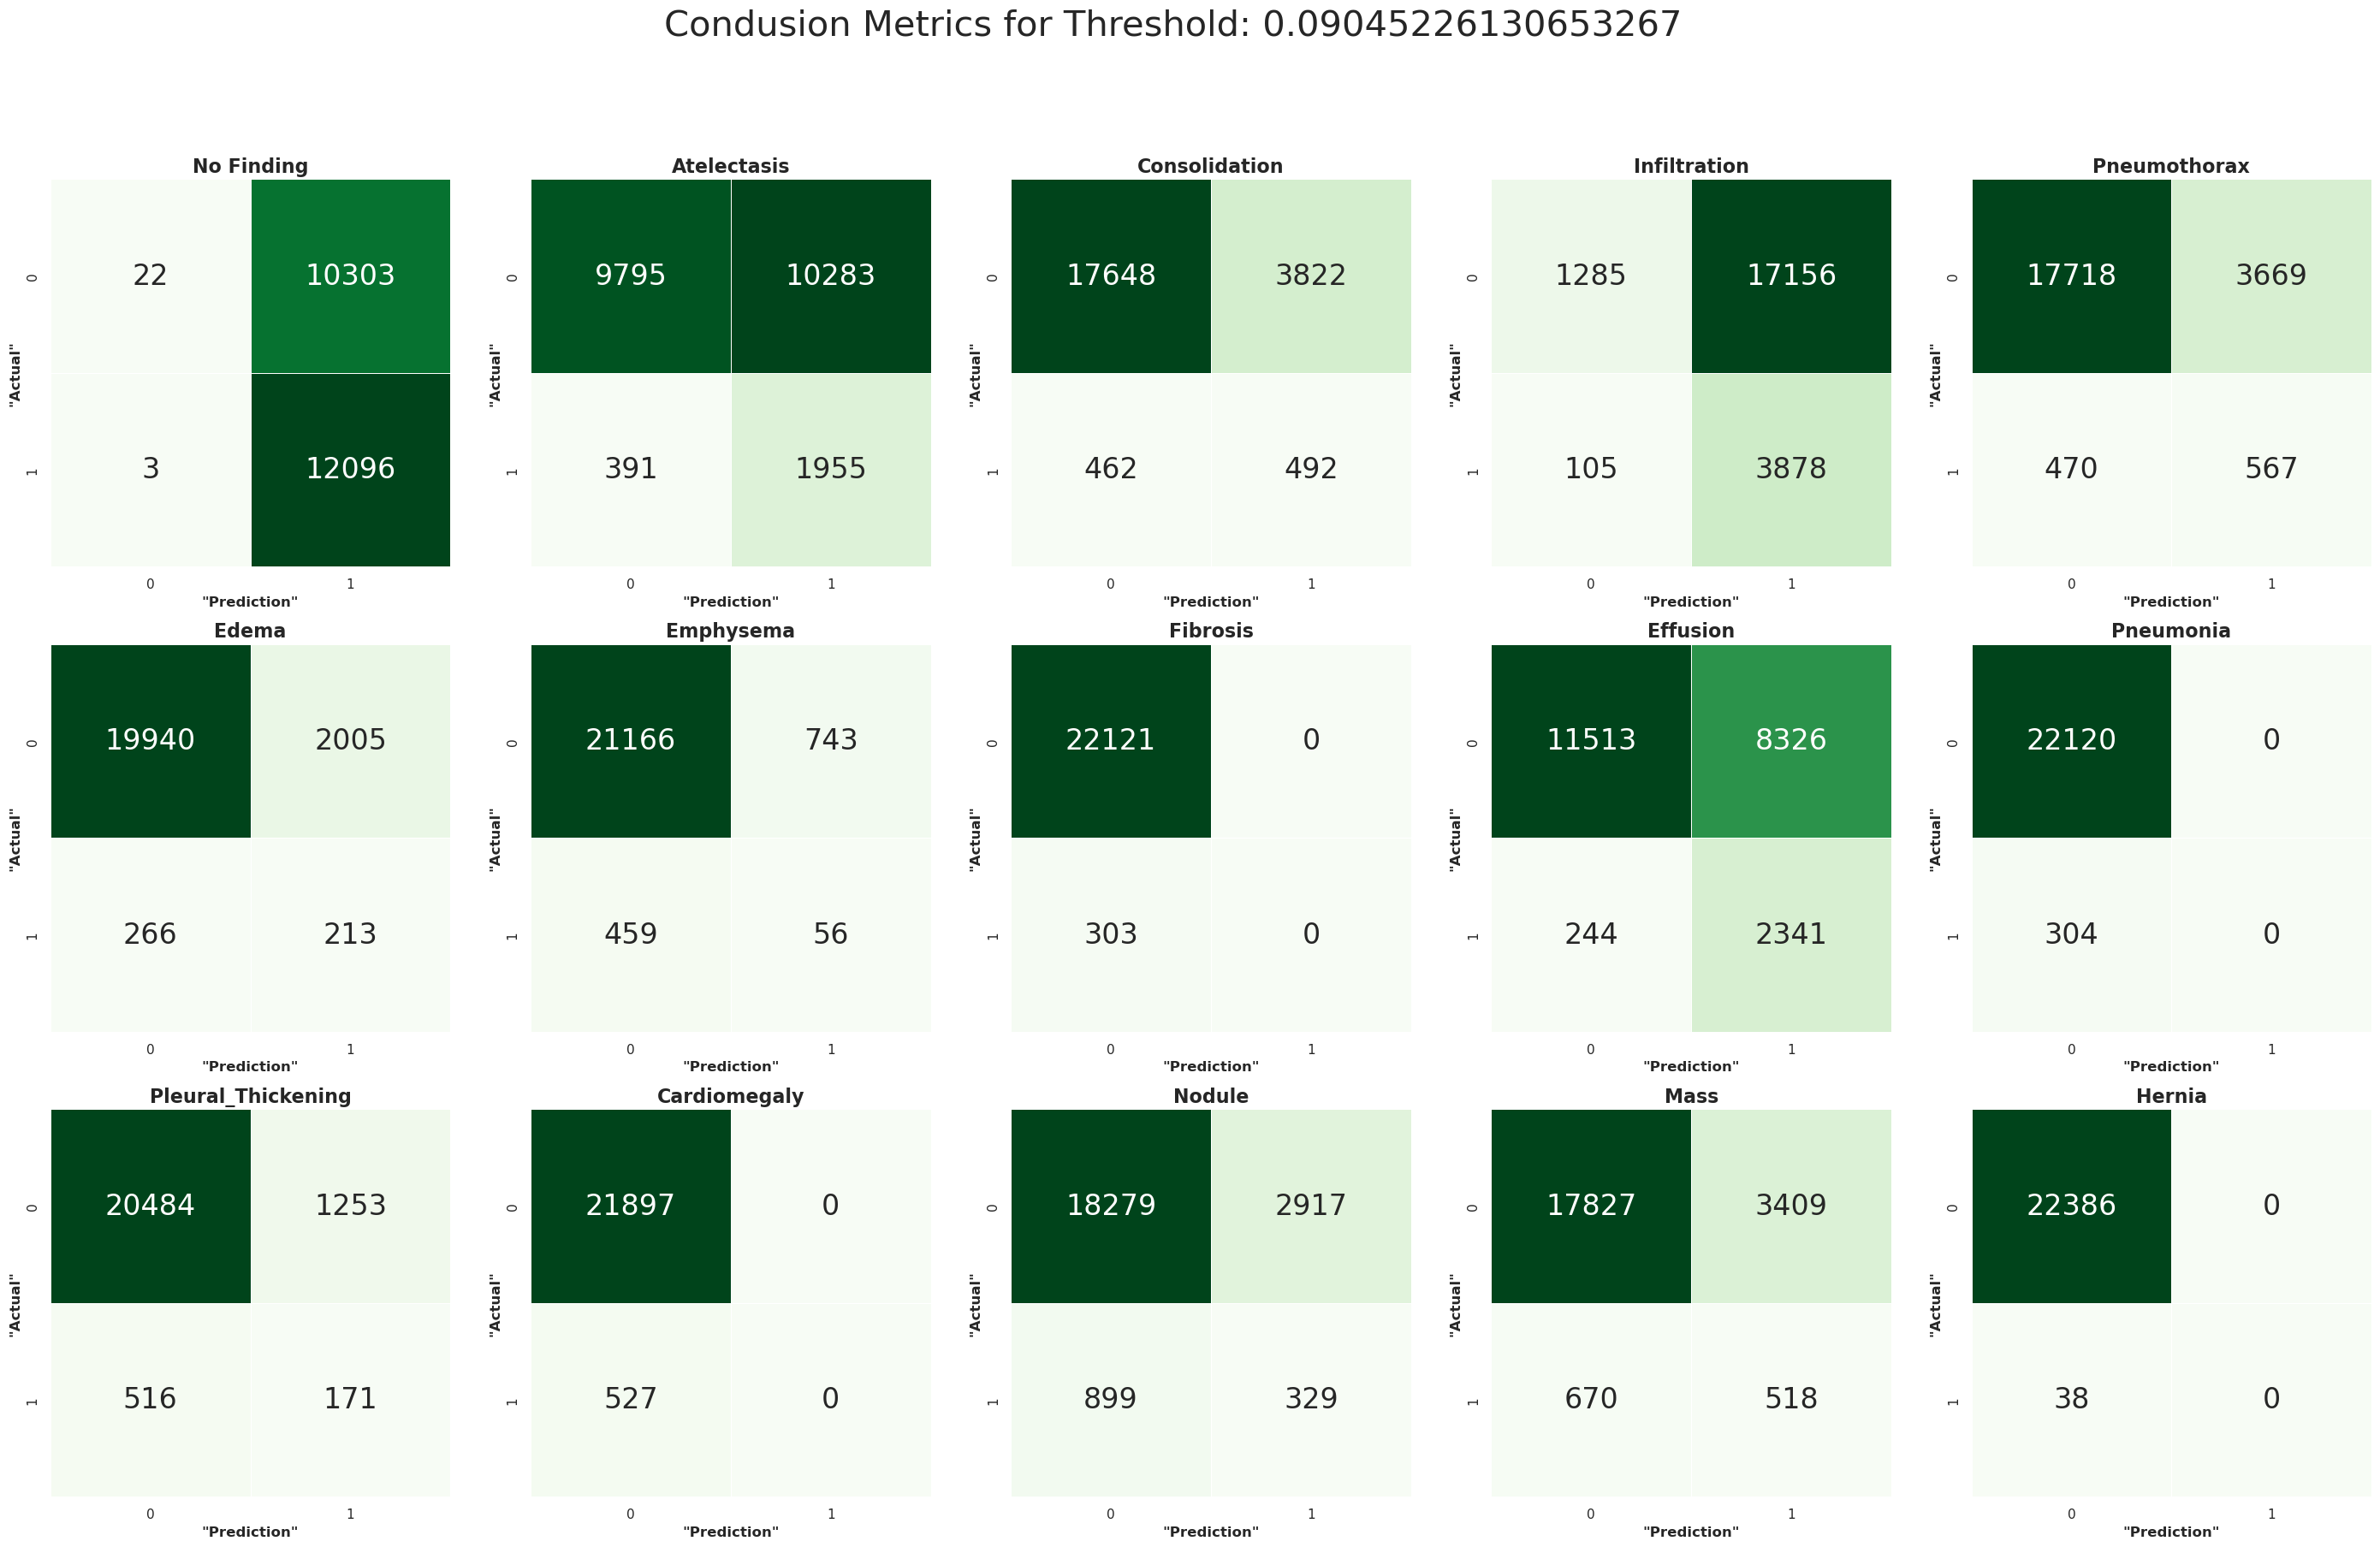

In [39]:
import numpy as np
import tensorflow_addons as tfa

for thresh_value in thresholds[:1]:
    thresh_value = thresholds[18]
    metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
    metric.update_state(y_true, 
                        np.greater_equal(y_preds, thresh_value).astype('int8'))
    result = metric.result()
    plot_confusion_metics(result, thresh_value)
    plt.show()
    # break

In [36]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 985.0 kB/s eta 0:00:0000:0100:01
